# 2D Material Bandgaps

In this notebook, we provide code to reproduce the results shown in our manuscript on the problem of predicting the badgap of 2D Materials using compositional and structural features.

In [130]:
import functools
import pickle
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import xgboost
import pymatgen
import xenonpy.descriptor
from tqdm.notebook import tqdm 
import sys, os

sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.functional import except_with_default_value
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.misc import root_mean_squared_error
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

from IPython.display import Latex

pd.options.mode.chained_assignment = None 
tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 42
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [102]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 32

# Read in the Data

To start, we'll read in the data. Then, we'll filter out the dataset with the following rules:

1. No elements from the f-block, anything larger than U, or noble gases
2. Decomposition energies must be below 0.5 eV
3. Exfoliation energies must be strictly positive

Also, because we utilize the Materials Project bandgap as a descriptor for the XGBoost and TPOT models, we necessarily must remove the bottom-up materials from the dataset. This is because only the top-down materials have corresponding entries on the Materials Project.

In [5]:
data = pd.read_pickle('../feature_engineering/full_featurized_data.pkl')


# Drop any missing entries
target_column = ["bandgap (eV)"]
data = data[data[target_column[0]].notna()]

# # Drop anything in the f-block, larger than U, and noble gases
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block
element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

# Drop anything that decomposes
decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

# Drop things with non-strictly-positive exfoliation energies
exfol_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

data = data[element_mask & decomposition_mask & exfol_mask]

# A parent Materials Project structure is not defined for the bottom-up materials. We waste our bandwith looking these up, so let's remove them.
data = data[data['discovery_process (unitless)'] != 'bottom-up']

Next up we'll query the Materials Project through PyMatGen for the bandgap of each material

In [6]:
rester = pymatgen.ext.matproj.MPRester(api_key=os.getenv("MATERIALS_PROJECT_API_KEY"))


@except_with_default_value(default_return=None)
def get_mp_bandgap(structure):
    mp_id = DigitalEcosystem.utils.misc.get_parent_structure_id(structure)
    
    result = rester.get_data(mp_id, prop='band_gap')[0]['band_gap']
    return result
    
data['mp_bandgap'] = data['2dm_id (unitless)'].progress_apply(get_mp_bandgap)

  0%|          | 0/1879 [00:00<?, ?it/s]

The above featurization takes a while, so let's just save it to disk. That way if we ever want to re-run this notebook, we don't have to re-do all those queries (and we save Materials Project some bandwidth)

In [9]:
data.to_pickle('filtered_data_with_bandgap.pkl')
#data = pd.read_pickle('filtered_data_with_bandgap.pkl')

Any entries from Materials Project that were missing a bandgap can get thrown away

In [13]:
# Finally, we'll filter the data with missing values for bandgap
data = data[data['mp_bandgap'].notna()]

In [15]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]

descriptors = xenonpy_descriptors + matminer_descriptors + ['mp_bandgap']

Finally, we'll show the dataframe, to get an idea of how much data we've filtered out.

In [109]:
data[['2dm_id (unitless)'] + target_column + descriptors]

,2dm_id (unitless),bandgap (eV),ave:Polarizability,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,...,bond_length_average,bond_angle_average,average_cn,global_instability,perimeter_area_ratio,ewald_energy_per_atom,structural complexity per atom,structural complexity per cell,n_symmetry_ops,mp_bandgap
2981,2dm-2992,2.1592,4.610000,19.000000,116.500000,206.000000,14.550000,41.865000,1376.700000,69.891020,...,1.854082,2.094256,3.000000,0.092784,1.438254,-53.898998,1.000000,2.000000,12.0,1.3711
2987,2dm-2998,0.0000,17.465000,7.500000,157.500000,230.000000,13.550000,15.622500,1240.575000,28.000000,...,NaN,NaN,0.000000,0.000000,1.451240,0.000000,1.000000,4.000000,12.0,0.0000
2988,2dm-2999,1.0572,4.400000,18.444444,133.000000,221.333333,12.877778,38.335897,1269.902222,36.722222,...,2.411893,1.722309,4.444444,0.226327,1.259362,-24.454789,2.281036,20.529325,12.0,0.9903
2989,2dm-3000,0.0000,7.800000,42.333333,151.333333,245.333333,16.450000,102.047167,2058.666667,96.666667,...,2.716969,1.475477,4.000000,0.023436,1.263086,-28.791123,0.918296,2.754888,12.0,0.0000
2990,2dm-3001,0.0000,3.275095,19.250000,94.500000,178.750000,12.957500,46.716000,1497.710000,120.099730,...,2.034599,1.528108,5.500000,NaN,1.301013,-5.868260,2.000000,16.000000,4.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,2dm-5918,0.7605,3.815429,23.428571,140.257954,195.857143,11.390000,53.561143,1710.108571,127.774880,...,2.129581,1.436120,4.571429,0.380834,0.519384,-40.435971,3.807355,106.605938,2.0,0.7136
5909,2dm-5920,1.7064,5.465455,48.545455,152.676141,239.454545,21.354545,115.302438,1239.529455,25.990909,...,3.112633,1.531910,3.636364,0.201037,0.526755,-8.469700,3.459432,76.107496,4.0,1.3399
5911,2dm-5922,1.0021,3.285000,33.000000,150.015363,214.000000,17.962500,77.330871,799.325000,32.200000,...,2.517111,NaN,2.250000,0.161920,0.359104,-11.448966,4.062500,130.000000,2.0,1.6253
5916,2dm-5927,0.9018,3.815429,23.428571,140.257954,195.857143,11.390000,53.561143,1710.108571,127.774880,...,2.141151,1.408620,4.642857,0.348107,0.530037,-40.618438,3.807355,106.605938,2.0,0.9614


# Prepare Data

Next up, we'll perform a train/test split, holding out 10% of the data as a test set.

In [34]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = np.nan_to_num(train[descriptors].to_numpy())
train_y = np.nan_to_num(train[target_column].to_numpy())

test_x = np.nan_to_num(test[descriptors].to_numpy())
test_y = np.nan_to_num(test[target_column].to_numpy())

In [126]:
metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': root_mean_squared_error,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

# XGBoost

XGBoost is a gradient boosting algorithm that uses an ensemble of decision trees. It's a very flexible model that comes with a lot of hyperparameters to tune. To tune them, we'll use Optuna, a Bayesian optimization framework. We'll also use Optuna to choose whether we use Z-score normalization or min/max scaling on the data.

We'll hold out 20% of the data as a validation set, for early-stopping and pruning purposes. We'll train the model to minimize its RMSE on the training set.

In [40]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 2),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 2),
        'max_depth': trial.suggest_int('max_depth', 1, 256),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=256,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    mse = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=current_reg.predict(objective_validation_x_reg),
    )
    rmse = np.sqrt(mse)

    return rmse

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=256),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

[I 2021-10-05 16:11:44,211] A new study created in memory with name: no-name-b3e851b0-7784-4523-b1a0-62fb039f333b
[I 2021-10-05 16:11:48,100] Trial 0 finished with value: 0.7336210129406551 and parameters: {'learning_rate': 0.749080237694725, 'min_split_loss': 1.9014286128198323, 'max_depth': 188, 'min_child_weight': 5.986584841970366, 'reg_lambda': 0.31203728088487304, 'reg_alpha': 0.3119890406724053, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7336210129406551.
[I 2021-10-05 16:11:49,707] Trial 1 finished with value: 0.729603568677646 and parameters: {'learning_rate': 1.2022300234864176, 'min_split_loss': 1.416145155592091, 'max_depth': 6, 'min_child_weight': 9.699098521619943, 'reg_lambda': 1.6648852816008435, 'reg_alpha': 0.4246782213565523, 'scaler': 'MinMaxScaler'}. Best is trial 1 with value: 0.729603568677646.
[I 2021-10-05 16:11:49,982] Trial 2 pruned. Trial was pruned at iteration 3.
[I 2021-10-05 16:11:50,130] Trial 3 pruned. Trial was pruned at iteration 1.
[I 

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


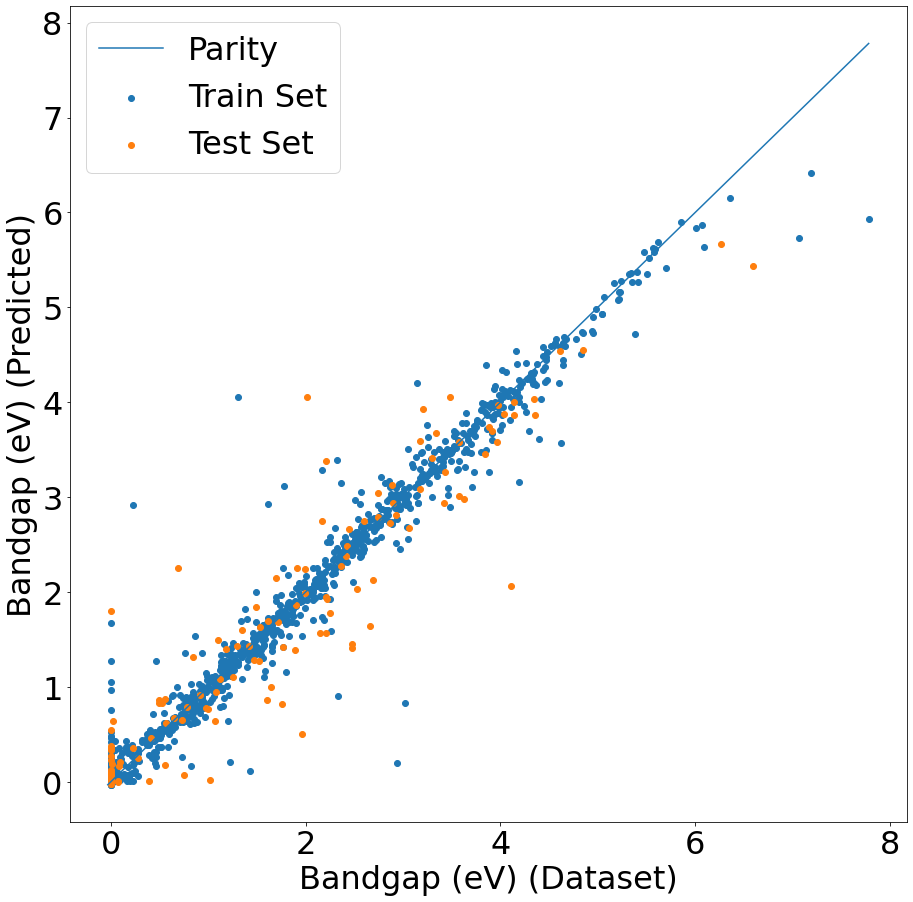

In [76]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = best_reg.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = best_reg.predict(test_x),
                                                                    axis_label = "Bandgap (eV)",
                                                                    filename = "xgboost_2dm_bandgap_parity.jpeg")

In [86]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 2.041
MAE 0.3108
MSE 0.248
RMSE 0.498
MAPE 159555155287487.56
R2 0.8923

Training Set Error Metrics
MaxError 2.7507
MAE 0.1168
MSE 0.0642
RMSE 0.2534
MAPE 72957204032215.34
R2 0.9729


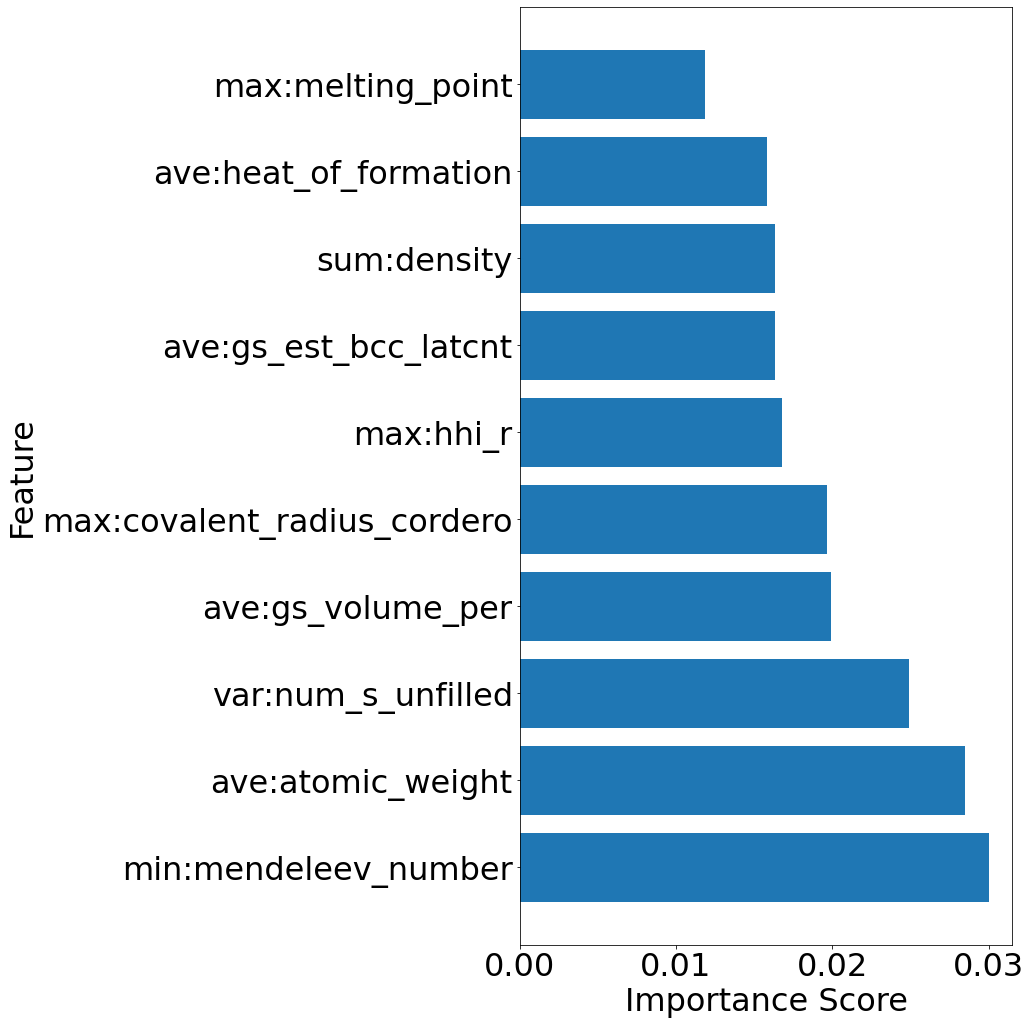

In [103]:
n_importances = 10
importances = list(zip(best_reg[1].feature_importances_, xenonpy_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))

plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("xgboost_2dm_bandgap_importances.jpeg")

Finally, for some book-keeping purposes, we'll go ahead and save the predictions from the XGBoost model, along with the importance scores from the above plot. Also, we'll go ahead and pickle the XGBoost pipeline.

In [88]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = best_reg.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = best_reg.predict(test_x)

xgb_predictions = train_preds.append(test_preds)
xgb_predictions.to_csv("xgboost_2dm_bandgap_predictions.csv")

In [91]:
with open("xgboost_2dm_bandgap_importances.csv", "w") as outp:
    outp.write("Descriptor,XGB_Importance\n")
    for importance, descriptor in sorted_importances:
        outp.write(f"{descriptor},{importance}\n")

In [100]:
with open("xgboost_pipeline.pkl", "wb") as outp:
    pickle.dump(best_reg, outp)

# TPOT

TPOT is an AutoML solution that uses a genetic algorithm to create an ML pipeline to address a given problem. Here, we'll run a population of 100 models over 10 generations, taking the 10-fold cross-validated RMSE as the fitness metric.

We'll also go ahead and save a parity plot of the TPOT model.

In [56]:
tpot_model = tpot.TPOTRegressor(
    generations=10,
    population_size=100,
    max_eval_time_mins=10 / 60,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

tpot_model.fit(train_x, train_y.ravel())

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.4412929205423147

Generation 2 - Current best internal CV score: -0.4412929205423147

Generation 3 - Current best internal CV score: -0.4412929205423147

Generation 4 - Current best internal CV score: -0.4412929205423147

Generation 5 - Current best internal CV score: -0.43823087510951797

Generation 6 - Current best internal CV score: -0.4382308751095178

Generation 7 - Current best internal CV score: -0.42913666917227467

Generation 8 - Current best internal CV score: -0.42913666917227467

Generation 9 - Current best internal CV score: -0.42913666917227467

Generation 10 - Current best internal CV score: -0.42913666917227467

Best pipeline: ElasticNetCV(MinMaxScaler(input_matrix), l1_ratio=0.9500000000000001, tol=1e-05)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


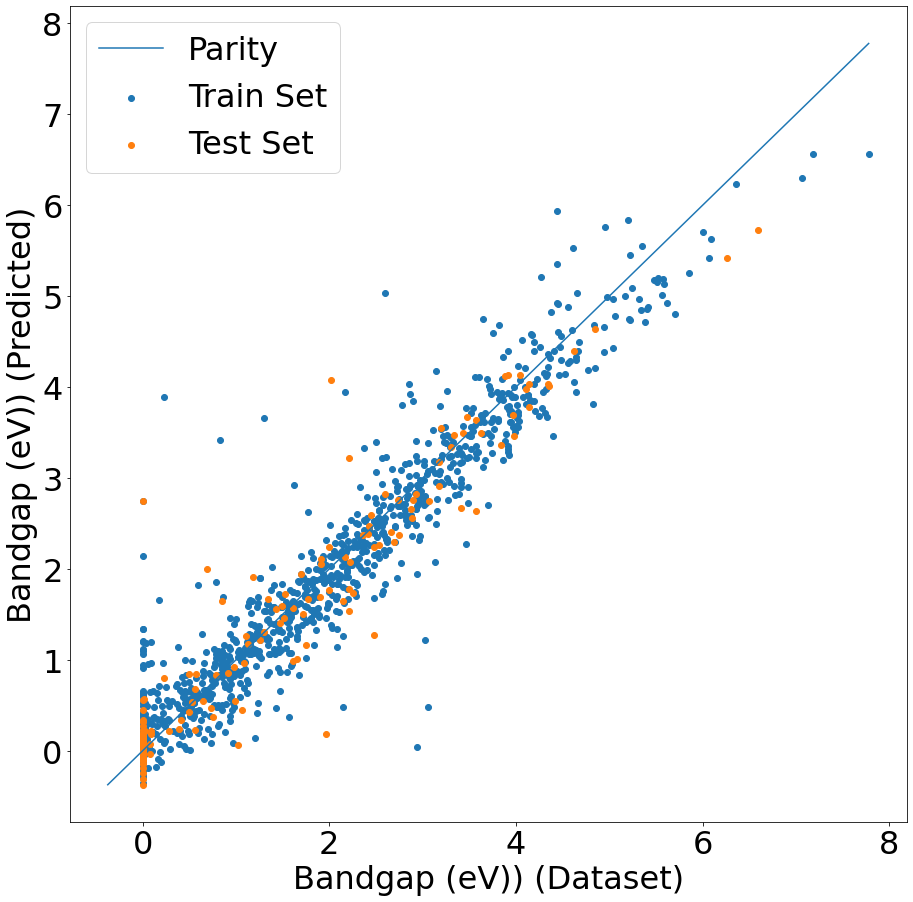

In [75]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = tpot_model.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = tpot_model.predict(test_x),
                                                                    axis_label = "Bandgap (eV))",
                                                                    filename = "tpot_2dm_bandgap_parity.jpeg")

In [69]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 2.7494
MAE 0.2941
MSE 0.2302
RMSE 0.4798
MAPE 270736960762340.72
R2 0.9001

Training Set Error Metrics
MaxError 3.6586
MAE 0.2664
MSE 0.1702
RMSE 0.4126
MAPE 236507185442103.97
R2 0.9281


Finally, we'll go ahead and back up those predictions to the disk (this way, we don't need to re-run this again just to get those), and we'll pickle the TPOT model. We'll also have TPOT auto-generate some Python code to re-train itself.

In [90]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = tpot_model.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = tpot_model.predict(test_x)

tpot_predictions = train_preds.append(test_preds)
tpot_predictions.to_csv("tpot_2dm_bandgap_predictions.csv")

At this point, a SISSO model was run. The models are stored below.

The model forms are from the SISSO logfiles. Coefficients have been copied directly from the SISSO outputs here.

In [99]:
tpot_model.export('tpot_autogenerated_pipeline.py')
with open("tpot_pipeline.pkl", "wb") as outp:
    pickle.dump(tpot_model.fitted_pipeline_, outp)

# Roost

[Roost](https://github.com/CompRhys/roost) is a neural network approach to predicting material properties as a function of their composition. Although we only have 144 data-points here, we can at least try for a good model.

Since the model only requires material IDs, the composition, and the property of interest, we'll save a CSV containing those properties.

In [44]:
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)
roost_data_train = train[['formula'] + target_column]
roost_data_test = test[['formula'] + target_column]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'), index_label='material_id')
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'), index_label='material_id')

At this point, Roost models were run. Logs can be found in the Roost directory, along with the resultant predictions.

In [47]:
roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

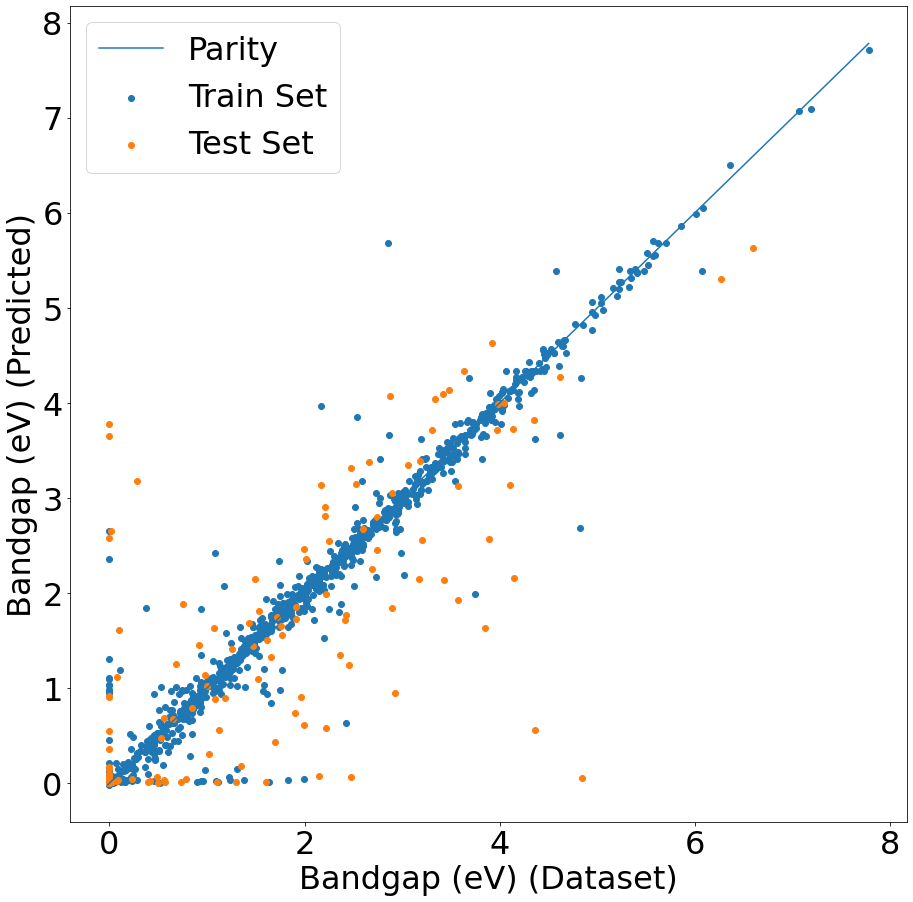

In [115]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = roost_train_results['bandgap_target'],
                                                                    train_y_pred =  roost_train_results['bandgap_pred_n0'],
                                                                    test_y_true = roost_test_results['bandgap_target'],
                                                                    test_y_pred = roost_test_results['bandgap_pred_n0'],
                                                                    axis_label = "Bandgap (eV)",
                                                                    filename = "roost_2dm_bandgap_parity.jpeg")

In [53]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_test_results['bandgap_target'], y_pred=roost_test_results['bandgap_pred_n0'])
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_train_results['bandgap_target'], y_pred=roost_train_results['bandgap_pred_n0'])
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 4.796
MAE 0.6532
MSE 1.1365
RMSE 1.0661
MAPE 430928609691678.9
R2 0.5066

Training Set Error Metrics
MaxError 2.827
MAE 0.1057
MSE 0.0755
RMSE 0.2748
MAPE 65116283251233.15
R2 0.9681


# SISSO

SISSO is a symbolic regression technique focused on creating interpretable machine learning models. 

Due to the exponential computational cost of running a SISSO model as the number of features and rungs increases, we need to restrict the feature space. To do that, we'll use LASSO-based feature selection (essentially we can look at how quickly LASSO extinguishes a variable to get an idea of its importance). 

In [37]:
sisso_feature_selector = sklearn.feature_selection.SelectFromModel(sklearn.linear_model.LassoCV(random_state=RANDOM_SEED),
                                                                   threshold=-np.inf,
                                                                   max_features=16,
                                                                   prefit=False)
sisso_feature_selector.fit(train_x, train_y.ravel())

sisso_features = [col for (col, is_selected) in zip(train[descriptors].columns, sisso_feature_selector.get_support()) if is_selected]
print("\n".join(sisso_features))

ave:Polarizability
ave:atomic_number
ave:atomic_radius
ave:atomic_radius_rahm
ave:atomic_volume
ave:atomic_weight
ave:boiling_point
ave:bulk_modulus
sum:hhi_p
var:boiling_point
var:c6_gb
var:hhi_p
var:hhi_r
var:melting_point
var:sound_velocity
var:thermal_conductivity


In [93]:
sisso_dir = "./sisso"
os.makedirs(sisso_dir, exist_ok=True)

sisso_data_train = train[target_column + sisso_features]
sisso_data_test = test[target_column + sisso_features]

sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_train.csv'), index_label='2dm_id (unitless)')
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_test.csv'), index_label='2dm_id (unitless)')

At this point, a SISSO model was run. The models are stored below.

The model forms are from the SISSO logfiles. For example, the "r1_1term" model corresponds with the 1-term model from rung 1.

The coefficients are extracted from the generated model `.dat` files, found in the `sisso/models` directory. 

In [147]:
sisso_models = {
    'r1_1term': lambda df: 5.865590038114292e+00 + \
                           -4.133268583136611e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_2term': lambda df: 5.456824304436886e+00 + \
                           5.806272825102222e-05 * (df['var:sound_velocity'] / df['ave:boiling_point']) + \
                           -3.928478305199087e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_3term': lambda df: 5.829318713354136e+00 + \
                           -2.895404136895635e-02 * (df['var:thermal_conductivity'] / df['ave:boiling_point']) + \
                           5.661787713744031e-05 * (df['var:sound_velocity'] / df['ave:boiling_point']) + \
                           -4.133601815903408e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_4term': lambda df: 4.239649765792811e+00 + \
                           3.209844715367811e-04 * (df['sum:hhi_p'] / df['ave:atomic_weight']) + \
                           -2.931356075881642e-02 * (df['var:thermal_conductivity'] / df['ave:boiling_point']) + \
                           5.565612620549401e-06 * (df['var:sound_velocity'] / df['ave:atomic_radius_rahm']) + \
                           -8.322616418822797e-02 * (np.sqrt(df['ave:boiling_point'])),
    
    'r2_1term': lambda df: -6.848927418726274e-01 + \
                           1.020330482802878e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_number']))),
    
    'r2_2term': lambda df: -7.037029355457204e-01 + \
                           -1.319062598081636e-03 * ((df['var:thermal_conductivity'] * df['ave:bulk_modulus']) / (df['ave:boiling_point'] * df['ave:Polarizability'])) + \
                           1.084886105825630e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_number']))),
    
    'r2_3term': lambda df: 1.288364460133121e+00 + \
                           -4.685654009911847e-02 * ((df['ave:atomic_number'] / df['ave:atomic_weight']) * (df['ave:atomic_radius_rahm'] - df['ave:atomic_radius'])) + \
                           -3.019449625791471e-05 * ((df['var:thermal_conductivity'] * df['var:boiling_point']) / (df['ave:boiling_point']**2)) + \
                           1.284011701624066e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_weight']))),
    
    'r2_4term': lambda df: 1.264193645822197e+00 + \
                           1.670730994972521e+01 * ((np.cbrt(df['var:thermal_conductivity'])) / (df['ave:bulk_modulus'] * df['ave:atomic_volume'])) + \
                           -5.358316290237519e-02 * ((df['ave:atomic_number'] / df['ave:atomic_weight']) * (df['ave:atomic_radius_rahm'] - df['ave:atomic_radius'])) + \
                           -3.794450825704627e-05 * ((df['var:thermal_conductivity'] * df['var:boiling_point']) / (df['ave:boiling_point']**2)) + \
                           1.281828774755674e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_weight'])))
}

for key, fun in sisso_models.items():
    print(f"==========\nSISSO Model {key}")
    sisso_train_predictions = fun(sisso_data_train)
    sisso_test_predictions = fun(sisso_data_test)
    sisso_data_train[key] = sisso_train_predictions
    sisso_data_test[key] = sisso_test_predictions
    
    print("\nTest Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_test['bandgap (eV)'], y_pred=sisso_test_predictions)
        print(metric,np.round(value,4))

    print("\nTraining Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_train['bandgap (eV)'], y_pred=sisso_train_predictions)
        print(metric,np.round(value,4))
    
    


SISSO Model r1_1term

Test Set Error Metrics
MaxError 4.6495
MAE 1.0029
MSE 1.6534
RMSE 1.2858
MAPE 1288599528693817.2
R2 0.2822

Training Set Error Metrics
MaxError 5.668
MAE 1.0209
MSE 1.6781
RMSE 1.2954
MAPE 1267340589721752.0
R2 0.2914
SISSO Model r1_2term

Test Set Error Metrics
MaxError 3.4279
MAE 0.955
MSE 1.4632
RMSE 1.2096
MAPE 1187365938345664.8
R2 0.3647

Training Set Error Metrics
MaxError 5.8156
MAE 0.9644
MSE 1.5153
RMSE 1.231
MAPE 1192265916695378.5
R2 0.3602
SISSO Model r1_3term

Test Set Error Metrics
MaxError 3.2849
MAE 0.9312
MSE 1.3844
RMSE 1.1766
MAPE 1144194559522530.0
R2 0.3989

Training Set Error Metrics
MaxError 6.0316
MAE 0.9328
MSE 1.4457
RMSE 1.2024
MAPE 1150596080695537.5
R2 0.3895
SISSO Model r1_4term

Test Set Error Metrics
MaxError 3.3996
MAE 0.9316
MSE 1.4135
RMSE 1.1889
MAPE 1140162333045965.5
R2 0.3863

Training Set Error Metrics
MaxError 6.0071
MAE 0.9211
MSE 1.3966
RMSE 1.1818
MAPE 1149247190995117.8
R2 0.4103
SISSO Model r2_1term

Test Set Error Me

Finally, we'll go ahead and save the predictions of the SISSO model on the training and test set.

In [148]:
sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_results_train.csv'))
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_results_test.csv'))

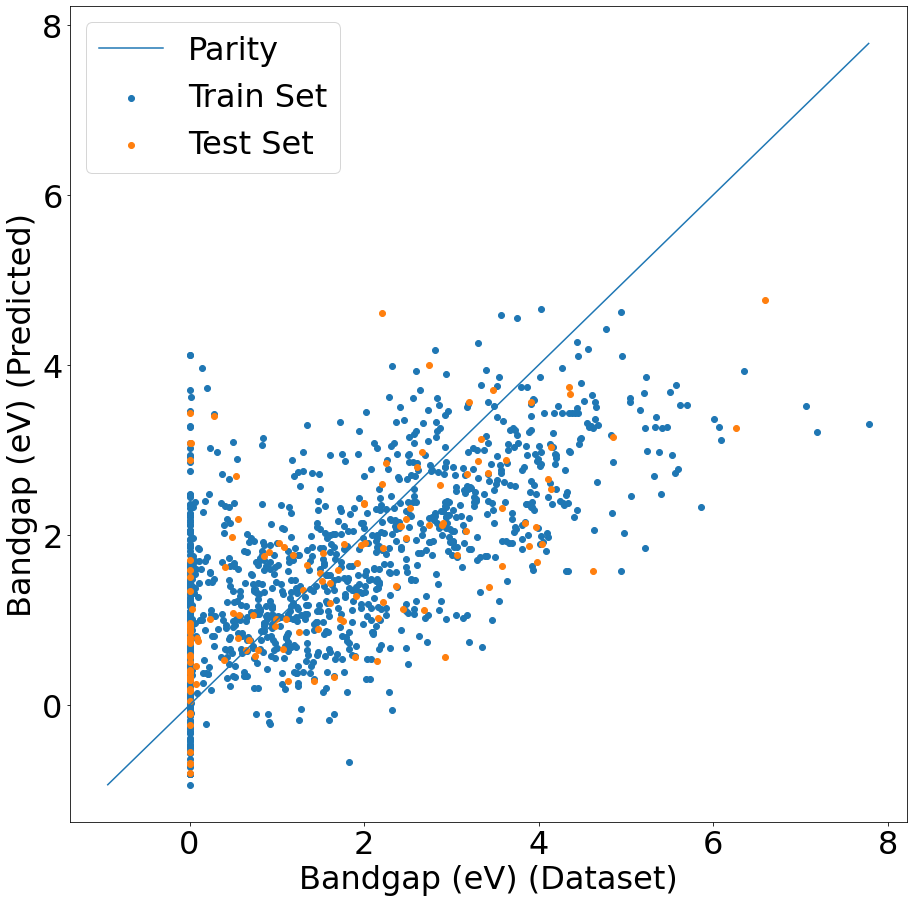

In [149]:
model_to_plot = 'r2_4term'
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['bandgap (eV)'],
                                                                    train_y_pred = sisso_data_train[model_to_plot],
                                                                    test_y_true = sisso_data_test['bandgap (eV)'],
                                                                    test_y_pred = sisso_data_test[model_to_plot],
                                                                    axis_label = "Bandgap (eV)",
                                                                    filename = "sisso_2dm_bandgap_parity.jpeg")

Finally, just so we have them, let's print out the rest of the SISSO models

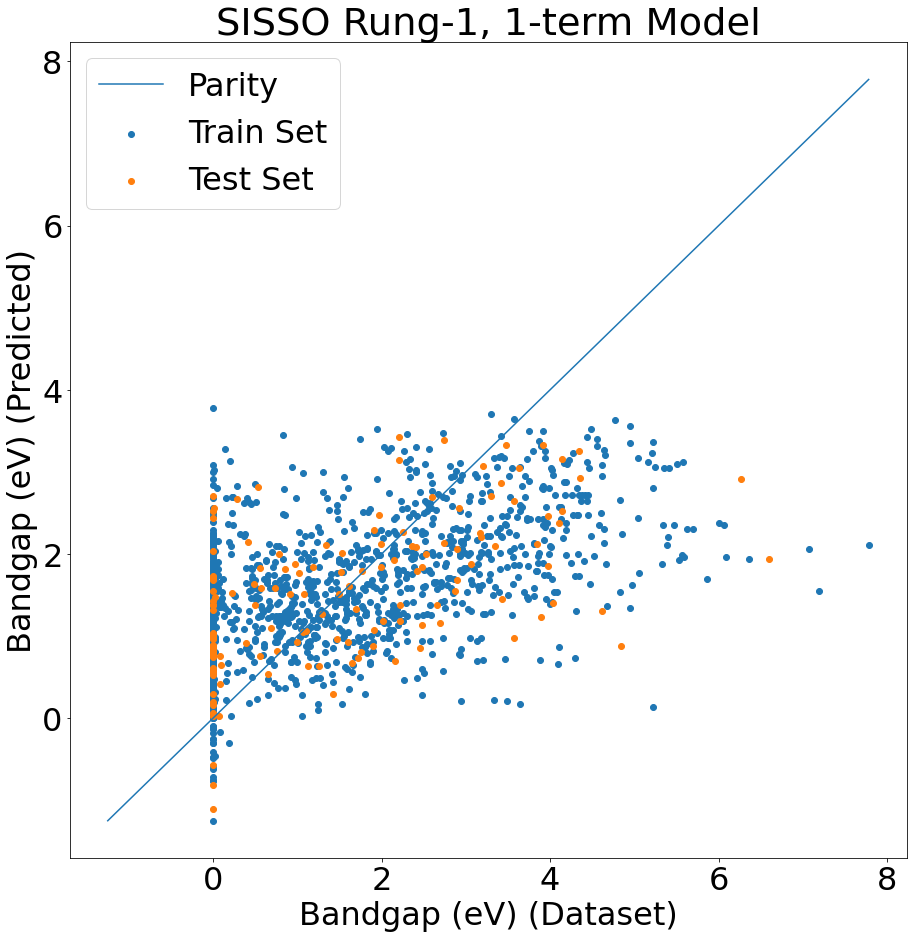

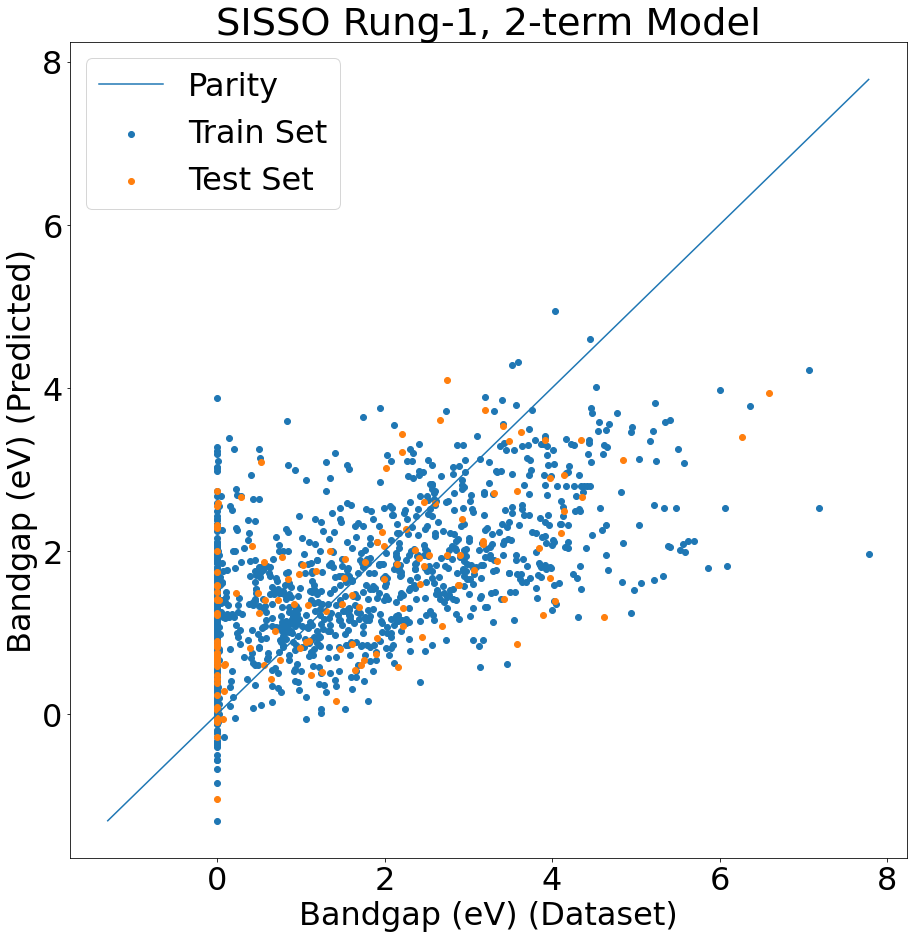

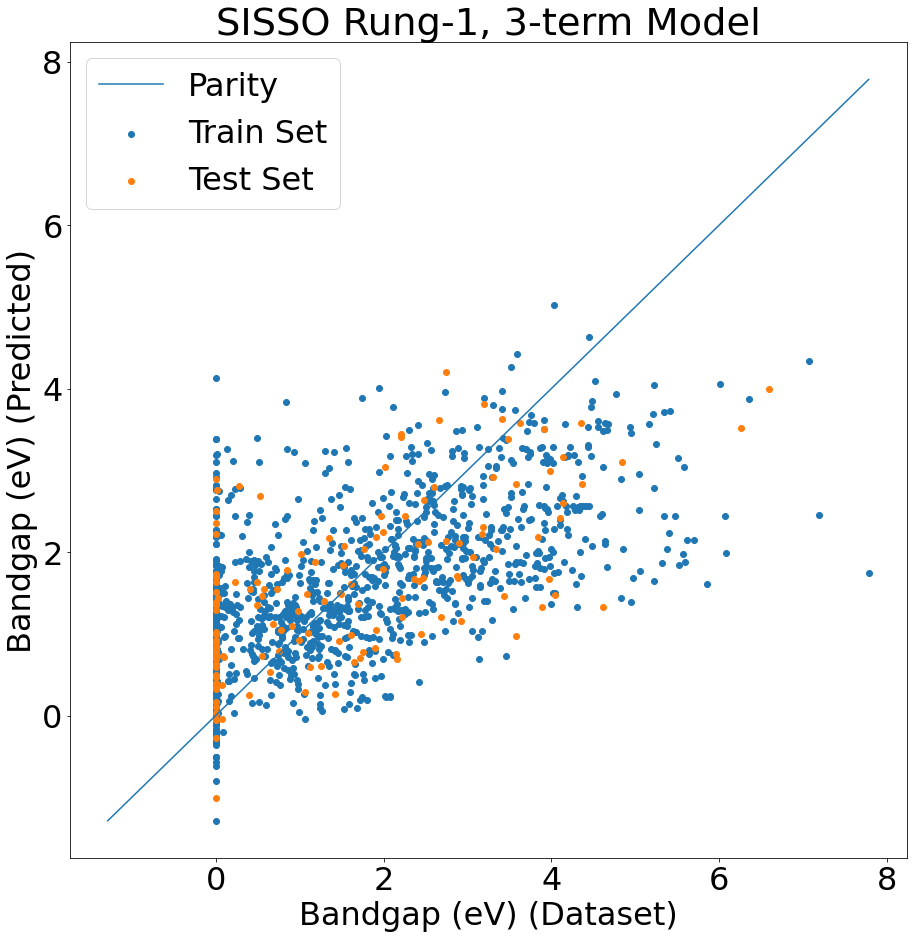

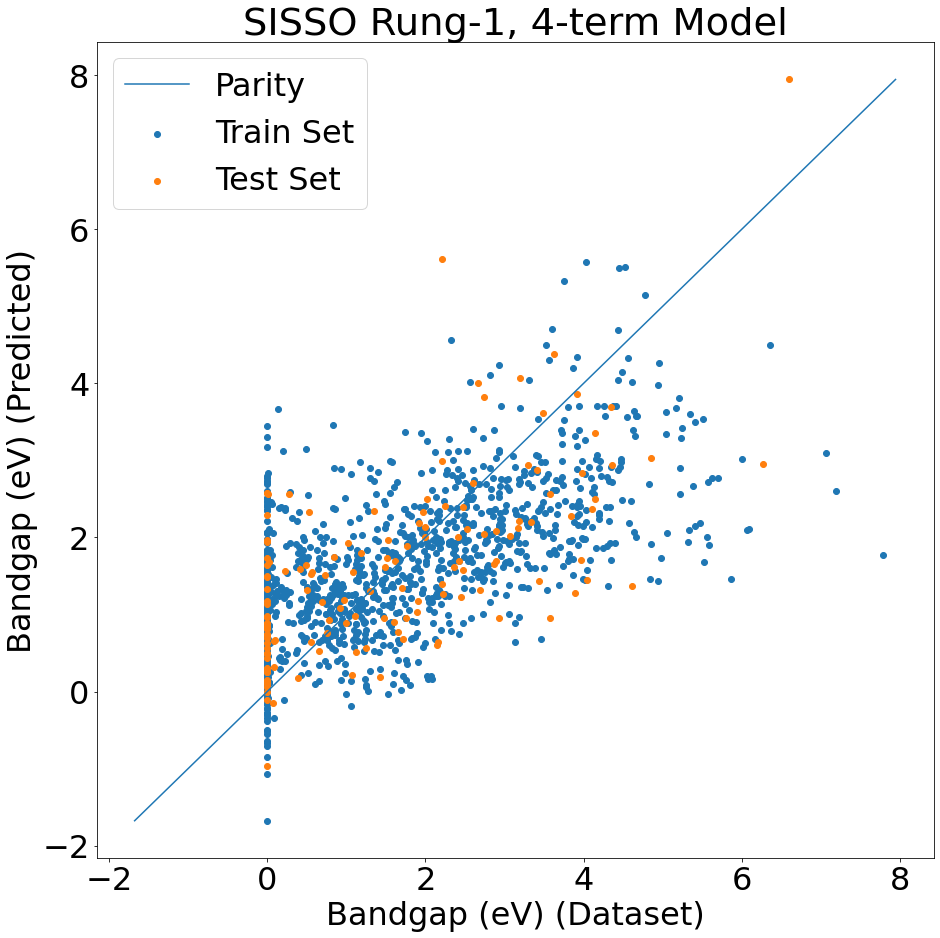

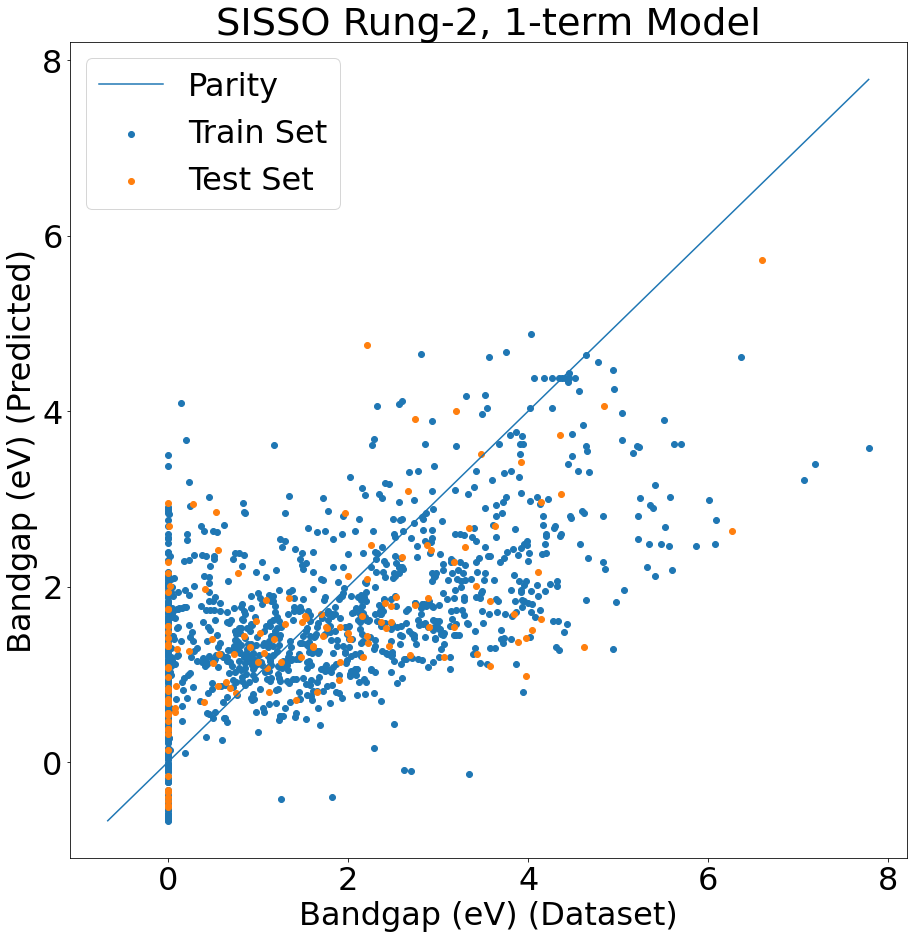

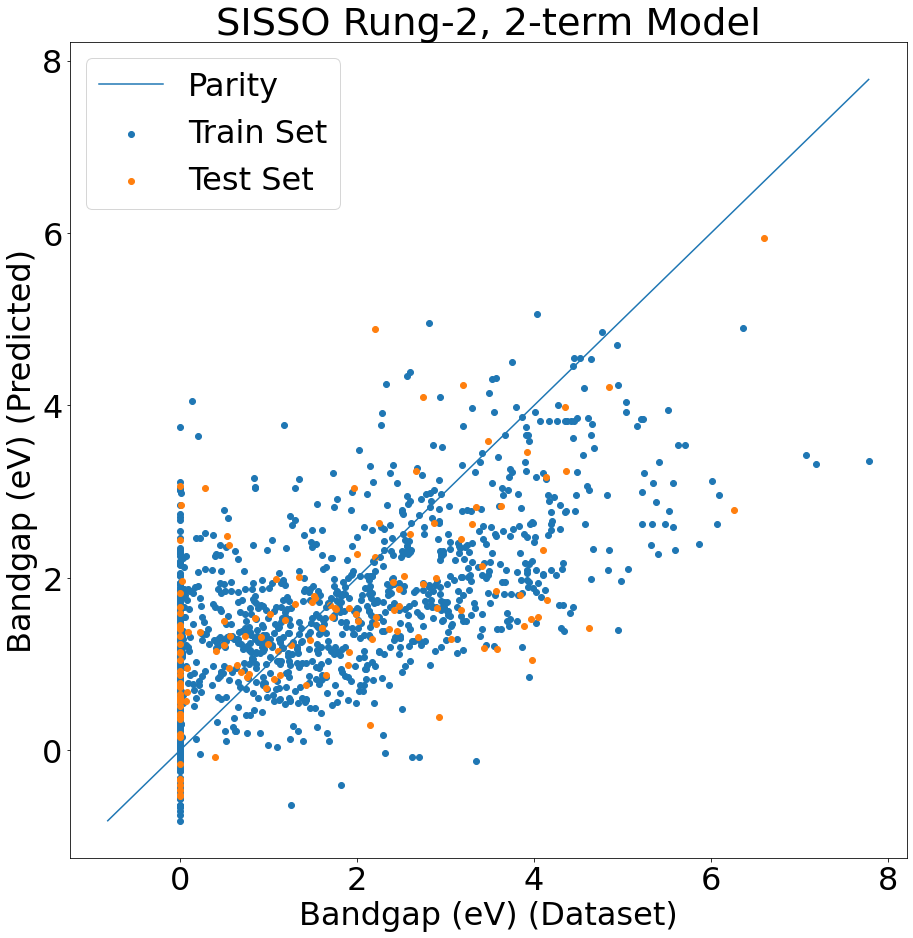

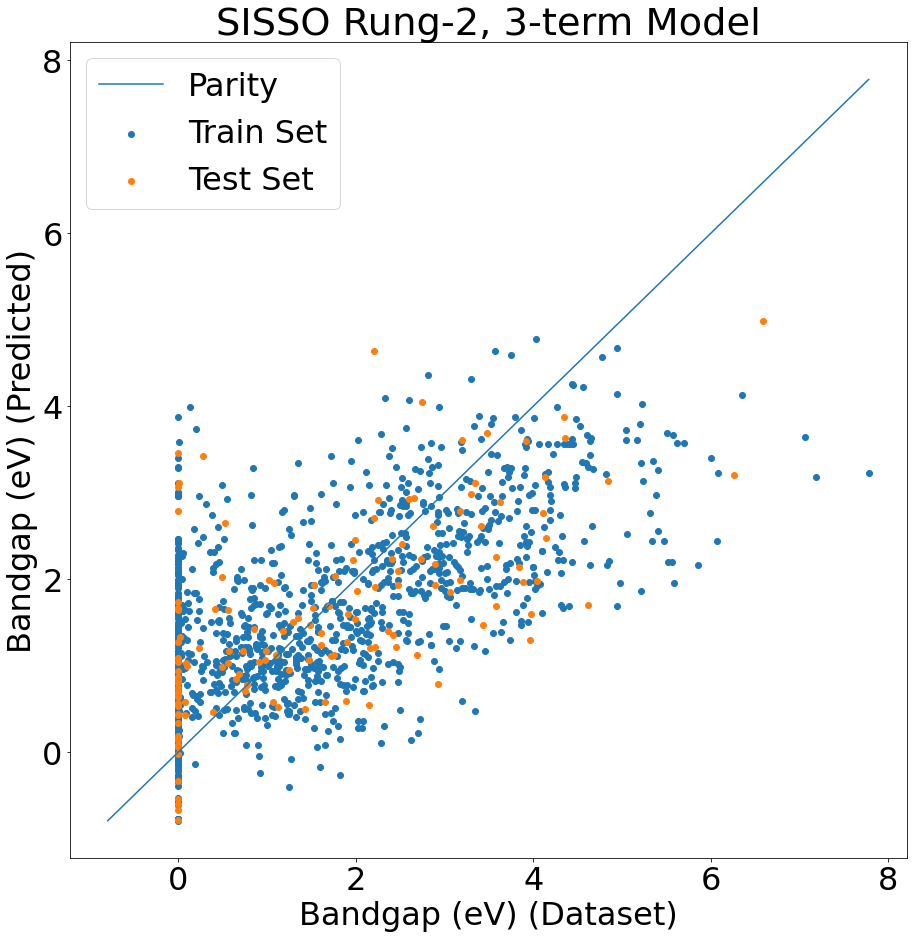

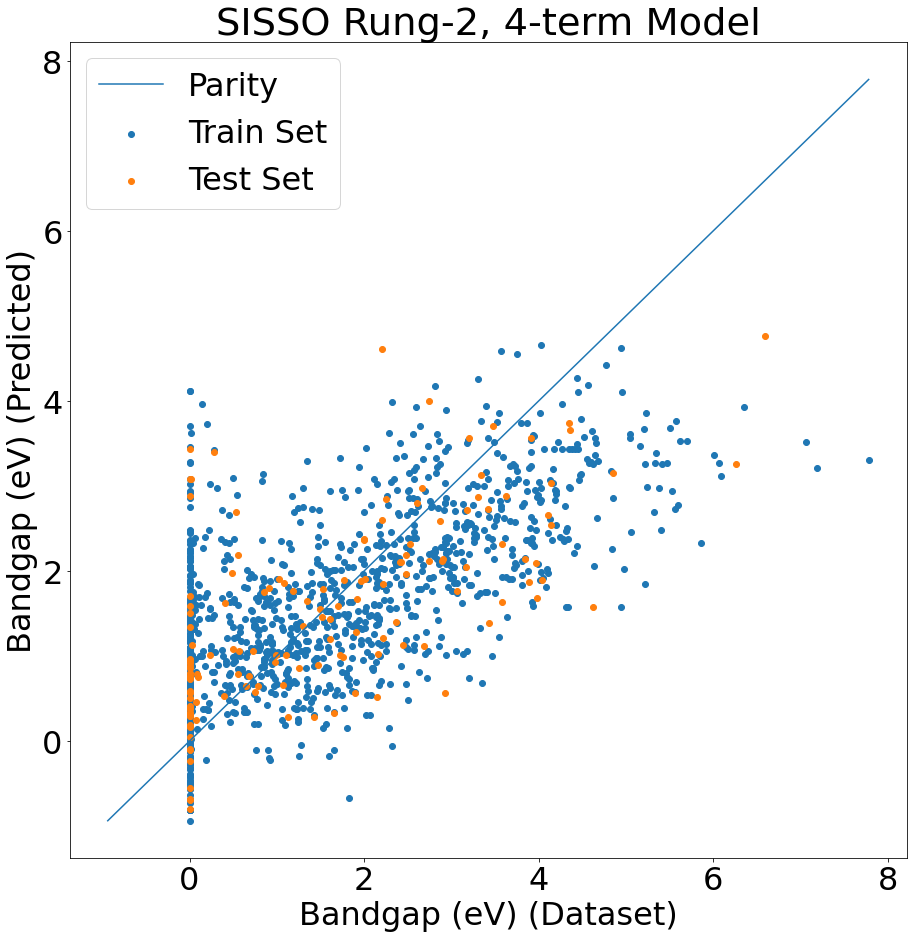

In [150]:
for model_to_plot in sisso_models.keys():
    DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['bandgap (eV)'],
                                                                        train_y_pred = sisso_data_train[model_to_plot],
                                                                        test_y_true = sisso_data_test['bandgap (eV)'],
                                                                        test_y_pred = sisso_data_test[model_to_plot],
                                                                        axis_label = "Bandgap (eV)",
                                                                        title=f'SISSO Rung-{model_to_plot[1]}, {model_to_plot[3]}-term Model')